<a href="https://colab.research.google.com/github/ricoprediansyah/CV-FASTER_RCNN_SUGARCANE/blob/main/FASTER_RCNN_TEBU_AUGMENTASI_%5BGAGAL%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##DATASET

In [ ]:

import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

No GPU available, using the CPU instead.


In [ ]:
import zipfile
import os

# Ganti 'yourfile.zip' dengan nama file ZIP Anda
zip_file = 'VOCRico.zip'

# Ekstrak file ZIP ke folder yang diinginkan (misalnya '/content/')
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall('/content/')

In [ ]:
# Membuat folder images dan annotations
!mkdir -p images annotations

In [ ]:
import os
print(f"Jumlah file: {len([f for f in os.listdir('/content/annotations') if os.path.isfile(os.path.join('/content/annotations', f))])}")

Jumlah file: 0


In [ ]:
import os
import shutil

# Daftar folder sumber
folders = ['/content/VOCRico']

# Membuat folder tujuan jika belum ada
os.makedirs('/content/images', exist_ok=True)
os.makedirs('/content/annotations', exist_ok=True)

# Memindahkan file berdasarkan ekstensi
for folder in folders:
    for filename in os.listdir(folder):
        file_path = os.path.join(folder, filename)

        # Memindahkan file .xml ke /content/annotations
        if filename.endswith('.xml'):
            shutil.move(file_path, '/content/annotations/')

        # Memindahkan file .png, .jpg, atau .jpeg ke /content/images
        elif filename.endswith(('.png', '.jpg', '.jpeg')):
            shutil.move(file_path, '/content/images/')

In [ ]:
print(f"Jumlah file: {len([f for f in os.listdir('/content/annotations') if os.path.isfile(os.path.join('/content/annotations', f))])}")

Jumlah file: 54


In [ ]:
import cv2
import albumentations as A
import xml.etree.ElementTree as ET
import numpy as np

# Fungsi untuk memperbarui bounding boxes setelah augmentasi
def update_bounding_boxes(augmentation, img, bboxes):
    # Mengonversi bboxes menjadi format NumPy array
    bboxes_np = np.array([bbox[:4] for bbox in bboxes], dtype=np.float32)
    class_labels = [bbox[4] for bbox in bboxes]

    # Melakukan augmentasi
    transformed = augmentation(image=img, bboxes=bboxes_np, class_labels=class_labels)

    # Mengonversi kembali bounding boxes menjadi list
    transformed_bboxes = transformed['bboxes'].tolist()

    return transformed['image'], transformed_bboxes

# Fungsi untuk membaca bounding boxes dari file XML PASCAL VOC
def parse_pascal_voc_xml(xml_file):
    if not os.path.exists(xml_file):
        return []
    tree = ET.parse(xml_file)
    root = tree.getroot()
    bboxes = []

    for obj in root.findall('object'):
        bbox = obj.find('bndbox')
        xmin = int(bbox.find('xmin').text)
        ymin = int(bbox.find('ymin').text)
        xmax = int(bbox.find('xmax').text)
        ymax = int(bbox.find('ymax').text)
        label = obj.find('name').text
        bboxes.append([xmin, ymin, xmax, ymax, label])

    return bboxes

# Fungsi untuk memperbarui XML dengan bounding boxes yang baru
def update_pascal_voc_xml(xml_file, new_bboxes):
    tree = ET.ElementTree(ET.Element("annotation"))
    root = tree.getroot()

    for new_bbox in new_bboxes:
        obj = ET.SubElement(root, "object")
        bbox = ET.SubElement(obj, "bndbox")
        ET.SubElement(bbox, "xmin").text = str(int(new_bbox[0]))
        ET.SubElement(bbox, "ymin").text = str(int(new_bbox[1]))
        ET.SubElement(bbox, "xmax").text = str(int(new_bbox[2]))
        ET.SubElement(bbox, "ymax").text = str(int(new_bbox[3]))
        ET.SubElement(obj, "name").text = "label"  # Anda mungkin ingin mengganti "label" dengan label sebenarnya

    # Simpan file XML yang sudah diperbarui
    tree.write(xml_file)

# Fungsi untuk melakukan augmentasi gambar
def augment_pascal_voc(image_path, xml_path):
    image = cv2.imread(image_path)
    bboxes = parse_pascal_voc_xml(xml_path)

    # Augmentasi
    augmentations = [
        ('flip_horizontal', A.HorizontalFlip(p=1)),
        ('flip_vertical', A.VerticalFlip(p=1)),
        ('rotate_45', A.Rotate(limit=(45, 45), p=1)),
        ('rotate_90', A.Rotate(limit=(90, 90), p=1)),
        ('brightness', A.RandomBrightnessContrast(brightness_limit=0.3, p=1)),
        ('contrast', A.RandomBrightnessContrast(contrast_limit=0.3, p=1))
    ]

    for aug_name, aug in augmentations:
        # Augment gambar dan bounding boxes
        transformed_image, transformed_bboxes = update_bounding_boxes(aug, image, bboxes)

        # Simpan gambar yang sudah diaugmentasi di folder yang sama
        image_filename = os.path.basename(image_path)
        output_image_path = os.path.join(os.path.dirname(image_path), f"{aug_name}_{image_filename}")
        cv2.imwrite(output_image_path, transformed_image)

        # Simpan XML dengan bounding boxes baru di folder yang sama
        new_xml_path = os.path.join(os.path.dirname(xml_path), f"{aug_name}_{os.path.basename(xml_path)}")
        update_pascal_voc_xml(new_xml_path, transformed_bboxes)

# Contoh penggunaan program
image_dir = '/content/images'
xml_dir = '/content/annotations'

# Ambil semua file gambar dan XML
for filename in os.listdir(image_dir):
    if filename.endswith('.jpg'):
        image_path = os.path.join(image_dir, filename)
        xml_path = os.path.join(xml_dir, filename.replace('.jpg', '.xml'))
        augment_pascal_voc(image_path, xml_path)

# Cek jumlah gambar dan anotasi
print("Jumlah gambar:", len(os.listdir(image_dir)))
print("Jumlah anotasi:", len(os.listdir(xml_dir)))

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.18 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


Jumlah gambar: 378
Jumlah anotasi: 378


In [ ]:
import os
import random
import numpy as np
import shutil

# Menghitung dan mencetak jumlah file di folder annotations dan images
print(f'Jumlah file di annotations: {len(os.listdir("annotations"))}')
print(f'Jumlah file di images: {len(os.listdir("images"))}')

# Membuat folder test_images dan test_annotations
os.makedirs('test_images', exist_ok=True)
os.makedirs('test_annotations', exist_ok=True)

# Mengatur seed untuk reproducibility
random.seed(1234)

# Menghitung jumlah dataset
total_data = 378
test_data_count = int(0.1 * total_data)  # 10% dari total_data

# Mengambil indeks secara acak untuk 10% data
idx = random.sample(range(total_data), test_data_count)

# Memindahkan file gambar ke test_images
for img in np.array(sorted(os.listdir('images')))[idx]:
    shutil.move(os.path.join('images', img), os.path.join('test_images', img))

# Memindahkan file anotasi ke test_annotations
for annot in np.array(sorted(os.listdir('annotations')))[idx]:
    shutil.move(os.path.join('annotations', annot), os.path.join('test_annotations', annot))

# Menghitung dan mencetak jumlah file setelah pemindahan
print(f'Jumlah file di annotations setelah pemindahan: {len(os.listdir("annotations"))}')
print(f'Jumlah file di images setelah pemindahan: {len(os.listdir("images"))}')
print(f'Jumlah file di test_annotations: {len(os.listdir("test_annotations"))}')
print(f'Jumlah file di test_images: {len(os.listdir("test_images"))}')

Jumlah file di annotations: 378
Jumlah file di images: 378
Jumlah file di annotations setelah pemindahan: 341
Jumlah file di images setelah pemindahan: 341
Jumlah file di test_annotations: 37
Jumlah file di test_images: 37


In [ ]:
import os
import numpy as np
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from PIL import Image
import torchvision
from torchvision import transforms, datasets, models
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import time
import torch
from torchvision import transforms

In [ ]:
def generate_box(obj):
    xmin = float(obj.find('xmin').text)
    ymin = float(obj.find('ymin').text)
    xmax = float(obj.find('xmax').text)
    ymax = float(obj.find('ymax').text)

    return [xmin, ymin, xmax, ymax]

In [ ]:
adjust_label = 0

def generate_label(obj):
    # Mengembalikan label 1 untuk class "Palm-Trees"
    if obj.find('name').text == "Palm-Tree":
        return 1 + adjust_label

    # Jika class tidak dikenali, kembalikan 0
    return 0 + adjust_label

In [ ]:
def generate_target(file):
    with open(file) as f:
        data = f.read()
        soup = BeautifulSoup(data, "html.parser")
        objects = soup.find_all("object")

        num_objs = len(objects)

        boxes = []
        labels = []
        for i in objects:
            boxes.append(generate_box(i))
            labels.append(generate_label(i))

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels

        return target

In [ ]:
def plot_image_from_output(img, annotation):

    img = img.cpu().permute(1,2,0)

    fig,ax = plt.subplots(1)
    ax.imshow(img)

    for idx in range(len(annotation["boxes"])):
        xmin, ymin, xmax, ymax = annotation["boxes"][idx]

        if annotation['labels'][idx] == 1 :
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='r',facecolor='none')

        else :

            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='orange',facecolor='none')

        ax.add_patch(rect)

    plt.show()

In [ ]:
class MaskDataset(object):
    def __init__(self, transforms, path):
        '''
        path: path to train folder or test folder
        '''
        # define the path to the images and what transform will be used
        self.transforms = transforms
        self.path = path
        self.imgs = list(sorted(os.listdir(self.path)))


    def __getitem__(self, idx): #special method
        # load images ad masks
        file_image = self.imgs[idx]
        file_label = self.imgs[idx][:-3] + 'xml'
        img_path = os.path.join(self.path, file_image)

        if 'test' in self.path:
            label_path = os.path.join("test_annotations/", file_label)
        else:
            label_path = os.path.join("annotations/", file_label)

        img = Image.open(img_path).convert("RGB")
        #Generate Label
        target = generate_target(label_path)

        if self.transforms is not None:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [ ]:
data_transform = transforms.Compose([  # transforms.Compose : a class that calls the functions in a list consecutively
        transforms.ToTensor() # ToTensor : convert numpy image to torch.Tensor type
    ])

def collate_fn(batch):
    return tuple(zip(*batch))

dataset = MaskDataset(data_transform, 'images/')
test_dataset = MaskDataset(data_transform, 'test_images/')

data_loader = torch.utils.data.DataLoader(dataset, batch_size=4, collate_fn=collate_fn)
test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=2, collate_fn=collate_fn)

In [ ]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

def get_model_instance_segmentation(num_classes, max_detections=1000):  # Ubah dari 300 ke 1000
    # Pretrained Faster R-CNN with ResNet-50 backbone
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

    # Replace the head of the box predictor with custom number of classes
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # Set the maximum number of detections per image (ubah default 100 ke max_detections)
    model.roi_heads.detections_per_img = max_detections

    return model

In [ ]:
# Instansiasi model dengan 2 kelas (Palm Tree + Background) dan set max 300 deteksi per gambar
model = get_model_instance_segmentation(2, max_detections=1000)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 163MB/s]


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [ ]:
torch.cuda.is_available()

True

In [ ]:
num_epochs = 25
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

In [ ]:
print('----------------------train start--------------------------')
for epoch in range(num_epochs):
    start = time.time()
    model.train()
    i = 0
    epoch_loss = 0
    for imgs, annotations in data_loader:
        i += 1
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        loss_dict = model(imgs, annotations)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        epoch_loss += losses
    print(f'epoch : {epoch+1}, Loss : {epoch_loss}, time : {time.time() - start}')

----------------------train start--------------------------


AssertionError: All bounding boxes should have positive height and width. Found invalid box [557.4130249023438, 142.84811401367188, 557.4130249023438, 143.3356475830078] for target at index 2.

In [ ]:
for epoch in range(num_epochs):
    start = time.time()
    model.train()
    epoch_loss = 0
    for imgs, annotations in data_loader:
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]

        # Periksa dan hapus kotak pembatas yang tidak valid
        for index, annotation in enumerate(annotations):
            boxes = annotation['boxes'].cpu().numpy()
            valid_boxes = []
            for box in boxes:
                xmin, ymin, xmax, ymax = box
                if xmax > xmin and ymax > ymin:  # Kotak valid
                    valid_boxes.append(box)

            # Jika ada kotak yang valid, update anotasi
            if valid_boxes:
                annotation['boxes'] = torch.tensor(valid_boxes, device=device)
            else:
                # Jika tidak ada kotak yang valid, kita tidak perlu mencetak pesan
                continue  # Skip annotation yang tidak valid

        # Hanya lanjut jika ada kotak valid
        if any(len(annotation['boxes']) > 0 for annotation in annotations):
            loss_dict = model(imgs, annotations)
            losses = sum(loss for loss in loss_dict.values())

            optimizer.zero_grad()
            losses.backward()
            optimizer.step()
            epoch_loss += losses
        else:
            # Tidak ada kotak valid ditemukan, jadi kita skip iterasi
            continue  # Skip iteration yang tidak valid

    print(f'epoch : {epoch+1}, Loss : {epoch_loss}, time : {time.time() - start}')

<ipython-input-25-54d12cedb6ea>:20: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  annotation['boxes'] = torch.tensor(valid_boxes, device=device)


epoch : 1, Loss : nan, time : 99.66301345825195
epoch : 2, Loss : nan, time : 95.20191693305969
epoch : 3, Loss : nan, time : 93.83773469924927
epoch : 4, Loss : nan, time : 93.84060144424438
epoch : 5, Loss : nan, time : 97.84324812889099
epoch : 6, Loss : nan, time : 93.26814699172974
epoch : 7, Loss : nan, time : 93.81414556503296
epoch : 8, Loss : nan, time : 95.97496700286865
epoch : 9, Loss : nan, time : 96.30894565582275
epoch : 10, Loss : nan, time : 94.12827587127686
epoch : 11, Loss : nan, time : 92.43851327896118
epoch : 12, Loss : nan, time : 92.79627108573914
epoch : 13, Loss : nan, time : 93.40250515937805
epoch : 14, Loss : nan, time : 93.48932266235352
epoch : 15, Loss : nan, time : 98.305251121521
epoch : 16, Loss : nan, time : 94.94002366065979
epoch : 17, Loss : nan, time : 93.7390685081482
epoch : 18, Loss : nan, time : 93.5309476852417
epoch : 19, Loss : nan, time : 92.66690349578857
epoch : 20, Loss : nan, time : 94.6594455242157
epoch : 21, Loss : nan, time : 92.

In [ ]:
torch.save(model.state_dict(),f'model_{num_epochs}.pt')

In [ ]:
model.load_state_dict(torch.load(f'model_{num_epochs}.pt'))

<ipython-input-28-3f9f79dbc0de>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'model_{num_epochs}.pt'))


<All keys matched successfully>

##TEST AND EVALUATION

In [ ]:
def make_prediction(model, img, threshold):
    model.eval()
    preds = model(img)
    for id in range(len(preds)) :
        idx_list = []

        for idx, score in enumerate(preds[id]['scores']) :
            if score > threshold :
                idx_list.append(idx)

        preds[id]['boxes'] = preds[id]['boxes'][idx_list]
        preds[id]['labels'] = preds[id]['labels'][idx_list]
        preds[id]['scores'] = preds[id]['scores'][idx_list]

    return preds

In [ ]:
with torch.no_grad():
    # batch size of the test set = 2
    for imgs, annotations in test_data_loader:
        imgs = list(img.to(device) for img in imgs)

        pred = make_prediction(model, imgs, 0.5)
        print(pred)
        break

[{'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}]


Target (Ground Truth):  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


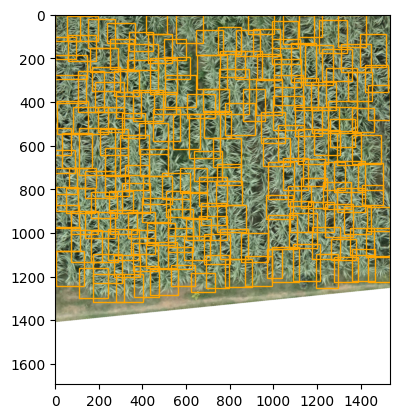

Prediction:  []


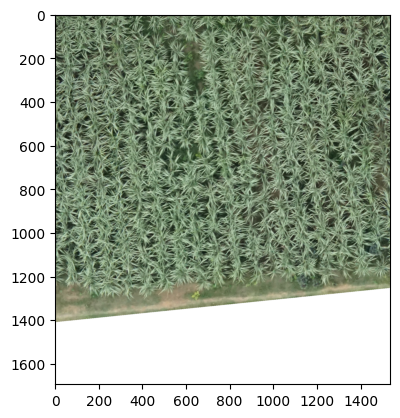

Jumlah label ground truth: 179
Jumlah label hasil prediksi: 0
Accuracy: 0.00%


In [ ]:
# Tentukan threshold untuk confidence score
threshold = 0.1

# GPU index untuk data yang digunakan
_idx = 1

# Pastikan tensor diubah menjadi numpy setelah dipindahkan ke CPU
print("Target (Ground Truth): ", annotations[_idx]['labels'].cpu().numpy())  # Pindahkan labels ke CPU sebelum dicetak

# Pindahkan gambar ke CPU untuk visualisasi
imgs_cpu = imgs[_idx].cpu()

# Pindahkan setiap tensor di dalam annotations (ground truth) ke CPU
annotations_cpu = {k: v.cpu().numpy() for k, v in annotations[_idx].items()}

# Visualisasikan gambar dan anotasi (ground truth)
plot_image_from_output(imgs_cpu, annotations_cpu)

# Pindahkan prediksi ke CPU
pred_cpu = {k: v.cpu().numpy() for k, v in pred[_idx].items()}

# Visualisasikan gambar dan prediksi
print("Prediction: ", pred_cpu['labels'])
plot_image_from_output(imgs_cpu, pred_cpu)

# Hitung label ground truth dan prediksi
ground_truth_labels = annotations[_idx]['labels'].cpu().numpy()
predicted_labels = pred_cpu['labels']

# Filter prediksi berdasarkan threshold
valid_indices = np.where(pred_cpu['scores'] >= threshold)[0]
predicted_labels = predicted_labels[valid_indices]

# Jumlah label asli (ground truth) dan hasil prediksi
print(f"Jumlah label ground truth: {len(ground_truth_labels)}")
print(f"Jumlah label hasil prediksi: {len(predicted_labels)}")

# Menghitung akurasi dengan membagi jumlah label hasil prediksi dengan jumlah label ground truth
accuracy = len(predicted_labels) / len(ground_truth_labels) * 100 if len(ground_truth_labels) > 0 else 0
print(f"Accuracy: {accuracy:.2f}%")

In [ ]:
from tqdm import tqdm

labels = []
preds_adj_all = []
annot_all = []

for im, annot in tqdm(test_data_loader, position = 0, leave = True):
    im = list(img.to(device) for img in im)

    for t in annot:
        labels += t['labels']

    with torch.no_grad():
        preds_adj = make_prediction(model, im, 0.5)
        preds_adj = [{k: v.to(torch.device('cpu')) for k, v in t.items()} for t in preds_adj]
        preds_adj_all.append(preds_adj)
        annot_all.append(annot)

100%|██████████| 19/19 [00:10<00:00,  1.87it/s]


In [ ]:
!git clone https://github.com/Pseudo-Lab/Tutorial-Book-Utils

Cloning into 'Tutorial-Book-Utils'...
remote: Enumerating objects: 45, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (39/39), done.
remote: Total 45 (delta 18), reused 17 (delta 5), pack-reused 0 (from 0)
Receiving objects: 100% (45/45), 11.62 KiB | 5.81 MiB/s, done.
Resolving deltas: 100% (18/18), done.


In [ ]:
!mv /content/Tutorial-Book-Utils/utils_ObjectDetection.py /content/

In [ ]:
import utils_ObjectDetection as utils

# Menghitung True Positives, pred_scores, dan pred_labels dari batch statistics
sample_metrics = []
for batch_i in range(len(preds_adj_all)):
    sample_metrics += utils.get_batch_statistics(preds_adj_all[batch_i], annot_all[batch_i], iou_threshold=0.5)

true_positives, pred_scores, pred_labels = [torch.cat(x, 0) for x in list(zip(*sample_metrics))]

# Menghitung Precision, Recall, dan F1 Score
precision, recall, ap, f1, ap_class = utils.ap_per_class(true_positives, pred_scores, pred_labels, torch.tensor(labels))

# Menghitung Akurasi
total_detections = true_positives.shape[0]  # Jumlah semua prediksi (TP + FP)
TP_sum = true_positives.sum()  # Jumlah True Positives
accuracy = TP_sum / total_detections  # Akurasi = TP / (TP + FP)

# Output hasil evaluasi
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-score: {f1}')
print(f'Accuracy: {accuracy.item()}')

Precision: tensor([0])
Recall: tensor([0])
F1-score: tensor([0.])
Accuracy: nan


In [ ]:
sample_metrics = []
for batch_i in range(len(preds_adj_all)):
    sample_metrics += utils.get_batch_statistics(preds_adj_all[batch_i], annot_all[batch_i], iou_threshold=0.5)

true_positives, pred_scores, pred_labels = [torch.cat(x, 0) for x in list(zip(*sample_metrics))]  # all the batches get concatenated
precision, recall, AP, f1, ap_class = utils.ap_per_class(true_positives, pred_scores, pred_labels, torch.tensor(labels))
mAP = torch.mean(AP)
print(f'mAP : {mAP}')
print(f'AP : {AP}')

RuntimeError: mean(): could not infer output dtype. Input dtype must be either a floating point or complex dtype. Got: Long

In [ ]:
# Hitung True Positives, pred_scores, dan pred_labels dari batch statistics
sample_metrics = []
for batch_i in range(len(preds_adj_all)):
    sample_metrics += utils.get_batch_statistics(preds_adj_all[batch_i], annot_all[batch_i], iou_threshold=0.5)

true_positives, pred_scores, pred_labels = [torch.cat(x, 0) for x in list(zip(*sample_metrics))]

# Menghitung Precision, Recall, dan F1 Score
precision, recall, ap, f1, ap_class = utils.ap_per_class(true_positives, pred_scores, pred_labels, torch.tensor(labels))

# Menghitung Akurasi
total_detections = true_positives.shape[0]  # Jumlah semua prediksi (TP + FP)
TP_sum = true_positives.sum()  # Jumlah True Positives
accuracy = TP_sum / total_detections if total_detections > 0 else 0  # Akurasi = TP / (TP + FP)


# Menghitung Mean Squared Error (MSE) dan Root Mean Squared Error (RMSE)
def calculate_mse_rmse(pred_scores, true_labels):
    """ Menghitung MSE dan RMSE """
    if len(pred_scores) != len(true_labels):
        raise ValueError("Jumlah prediksi dan jumlah label harus sama.")

    # Menghitung MSE
    mse = torch.mean((pred_scores - true_labels) ** 2)
    rmse = torch.sqrt(mse)

    return mse.item(), rmse.item()

# Filter pred_scores dan true_labels untuk memastikan ukurannya sama
valid_indices = true_positives.nonzero(as_tuple=True)[0]  # Ambil indeks True Positives

# Memastikan filtered_pred_scores dan filtered_true_labels memiliki ukuran yang sama
if len(valid_indices) > 0:
    filtered_pred_scores = pred_scores[valid_indices]

    # Ambil true labels yang sesuai dengan pred_labels
    filtered_true_labels = pred_labels[valid_indices]

    # Hitung MSE dan RMSE
    mse, rmse = calculate_mse_rmse(filtered_pred_scores, filtered_true_labels)

    # Output hasil MSE dan RMSE
    print(f'Mean Squared Error (MSE): {mse}')
    print(f'Root Mean Squared Error (RMSE): {rmse}')
else:
    print("Tidak ada True Positives yang ditemukan.")

Tidak ada True Positives yang ditemukan.
